# IMPORTS

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ICUSI/utils_fn')

In [ ]:
from tensorflow import keras
from keras import layers, models, utils
from keras.optimizers import Adam
import numpy as np
from pathlib import Path
from generate_dataset import *
from plot_history import *
from generate_classification_report import *
from plot_confusion_matrix import *
from predict_image import *

utils.set_random_seed(42)

# CONSTANTS

In [ ]:
DATASET_DIR = Path("/content/drive/MyDrive/Romanian-Sign-Language-Image-Classification/Ro_Sign_language_Dataset")
MODEL_SAVE_DIR = Path("/content/drive/MyDrive/Romanian-Sign-Language-Image-Classification/Saves")
SAVE_NAME = f'VGG16'

BATCH_SIZE = 64
IMAGE_SIZE = (128, 128)
EPOCHS = 50

# PREPROCESSING

In [ ]:
train_dataset, validation_dataset, test_dataset = generate_dataset(base_dir=DATASET_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Found 15600 files belonging to 26 classes.
Found 5200 files belonging to 26 classes.
Found 5200 files belonging to 26 classes.


## ARCHITECTURE

In [ ]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False,
                                           input_shape=(128, 128, 3))

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


In [ ]:
train_features.shape

(15600, 4, 4, 512)

In [ ]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(26, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)

vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 26)                6682      
                                                                 
Total params: 2104090 (8.03 MB)
Trainable params: 2104090 (8.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(26, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)

vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 sequential (Sequential)     (None, 4, 4, 512)         0         
                                                                 
 rescaling (Rescaling)       (None, 4, 4, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 26)                6682

In [ ]:
vgg16_model.compile(loss="categorical_crossentropy",
                               optimizer="adam",
                               metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath = str(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}_extract.model.keras'),
                                             save_best_only=True,
                                             monitor="val_loss")]

history = vgg16_model.fit(train_features, train_labels,
                          epochs=50,
                          validation_data=(val_features, val_labels),
                          callbacks=callbacks)

np.save(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}_extract.history.npy', history.history)

Epoch 1/50
488/488 [==============================] - 7s 13ms/step - loss: 0.6852 - accuracy: 0.9021 - val_loss: 0.3593 - val_accuracy: 0.8963
Epoch 2/50
488/488 [==============================] - 6s 12ms/step - loss: 0.0604 - accuracy: 0.9954 - val_loss: 0.2219 - val_accuracy: 0.9352
Epoch 3/50
488/488 [==============================] - 6s 12ms/step - loss: 0.0271 - accuracy: 0.9973 - val_loss: 0.2430 - val_accuracy: 0.9108
Epoch 4/50
488/488 [==============================] - 6s 13ms/step - loss: 0.0147 - accuracy: 0.9989 - val_loss: 0.1926 - val_accuracy: 0.9377
Epoch 5/50
488/488 [==============================] - 6s 13ms/step - loss: 0.0108 - accuracy: 0.9988 - val_loss: 0.2570 - val_accuracy: 0.9196
Epoch 6/50
488/488 [==============================] - 6s 12ms/step - loss: 0.0079 - accuracy: 0.9992 - val_loss: 0.2015 - val_accuracy: 0.9367
Epoch 7/50
488/488 [==============================] - 6s 12ms/step - loss: 0.0068 - accuracy: 0.9992 - val_loss: 0.2344 - val_accuracy: 0.9302

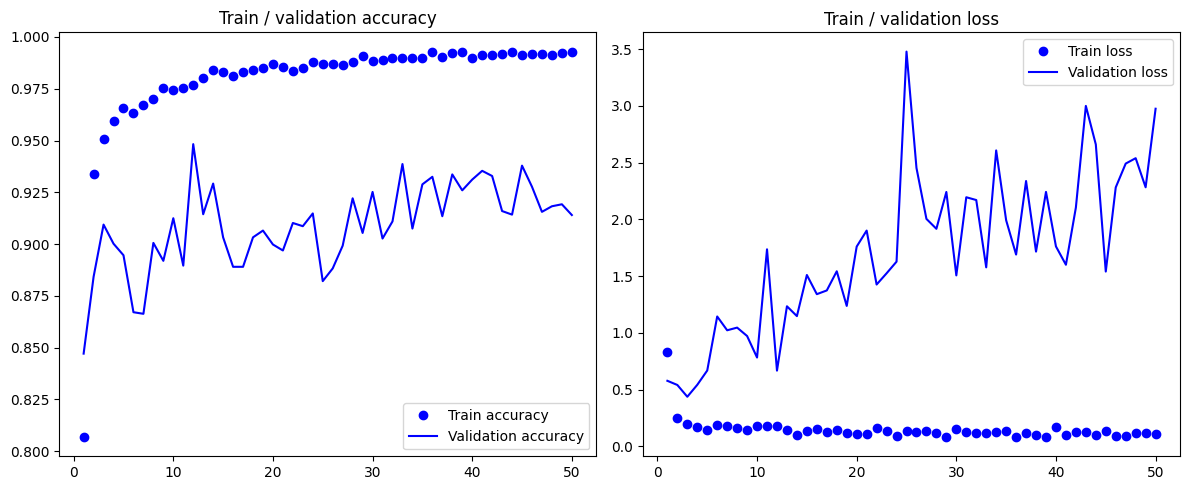

In [ ]:
history = np.load('/content/drive/MyDrive/ICUSI/vggs.history.npy', allow_pickle=True).item()
plot_history(history)

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
vgg16_model.compile(loss="categorical_crossentropy",
                    optimizer=Adam(learning_rate=0.0001),
                    metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath = str(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.model.keras'),
                                             save_best_only=True,
                                             monitor="val_loss")]

history = vgg16_model.fit(train_features, train_labels,
                          epochs=50,
                          validation_data=(val_features, val_labels),
                          callbacks=callbacks)

np.save(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.history.npy', history.history)

Epoch 1/50
488/488 [==============================] - 5s 9ms/step - loss: 0.0481 - accuracy: 0.9946 - val_loss: 2.6300 - val_accuracy: 0.9210
Epoch 2/50
488/488 [==============================] - 4s 8ms/step - loss: 0.0433 - accuracy: 0.9953 - val_loss: 2.7009 - val_accuracy: 0.9212
Epoch 3/50
488/488 [==============================] - 4s 8ms/step - loss: 0.0342 - accuracy: 0.9963 - val_loss: 2.6398 - val_accuracy: 0.9210
Epoch 4/50
488/488 [==============================] - 4s 8ms/step - loss: 0.0292 - accuracy: 0.9961 - val_loss: 2.6602 - val_accuracy: 0.9217
Epoch 5/50
488/488 [==============================] - 4s 8ms/step - loss: 0.0234 - accuracy: 0.9967 - val_loss: 2.7295 - val_accuracy: 0.9208
Epoch 6/50
488/488 [==============================] - 4s 8ms/step - loss: 0.0251 - accuracy: 0.9974 - val_loss: 2.6113 - val_accuracy: 0.9225
Epoch 7/50
488/488 [==============================] - 4s 8ms/step - loss: 0.0275 - accuracy: 0.9965 - val_loss: 2.6256 - val_accuracy: 0.9231
Epoch 

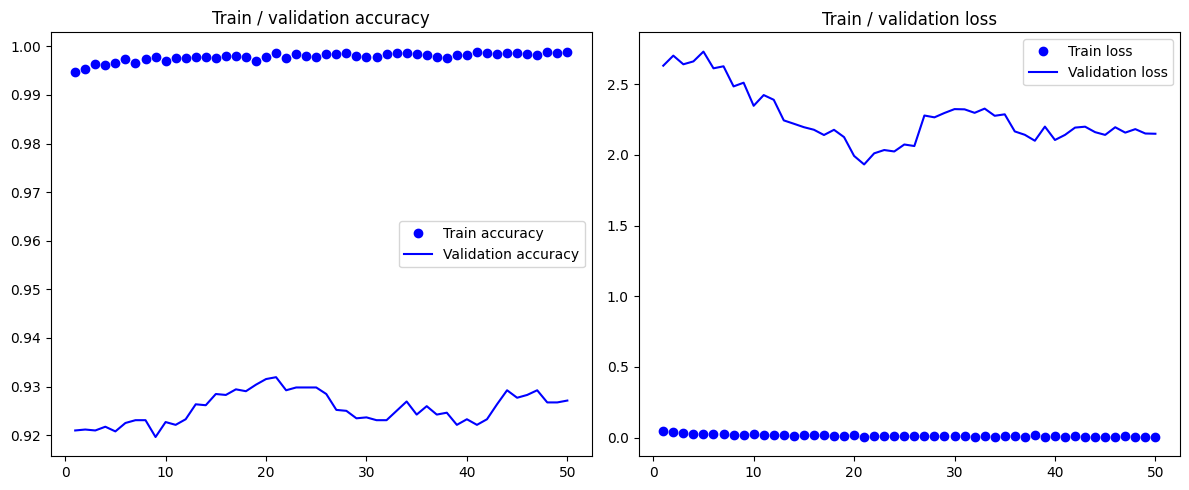

In [ ]:
history = np.load(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.history.npy', allow_pickle=True).item()
plot_history(history)

## EVALUATION

In [ ]:
vgg16_model = keras.models.load_model(MODEL_SAVE_DIR / SAVE_NAME / f'{SAVE_NAME}.model.keras')
test_loss, test_acc = vgg16_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

163/163 [==============================] - 1s 6ms/step - loss: 3.3068 - accuracy: 0.8923
Test accuracy: 0.892


In [ ]:
generate_classification_report(vgg16_model, test_dataset, features=test_features, labels=test_labels)

163/163 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           A       0.78      1.00      0.88       200
          Â       0.99      1.00      1.00       200
          Ă       0.99      0.99      0.99       200
           B       0.90      0.98      0.94       200
           C       0.95      1.00      0.98       200
           D       0.99      0.41      0.58       200
           E       0.96      0.67      0.78       200
           F       0.98      0.99      0.99       200
           G       1.00      0.96      0.98       200
           H       0.96      1.00      0.98       200
           I       0.97      0.76      0.85       200
           K       0.84      0.97      0.90       200
           L       0.97      1.00      0.99       200
           M       0.55      0.88      0.67       200
           N       0.81      0.27      0.40       200
           O       0.71      1.00      0.83       200
           P       0.98   

163/163 [==============================] - 1s 5ms/step


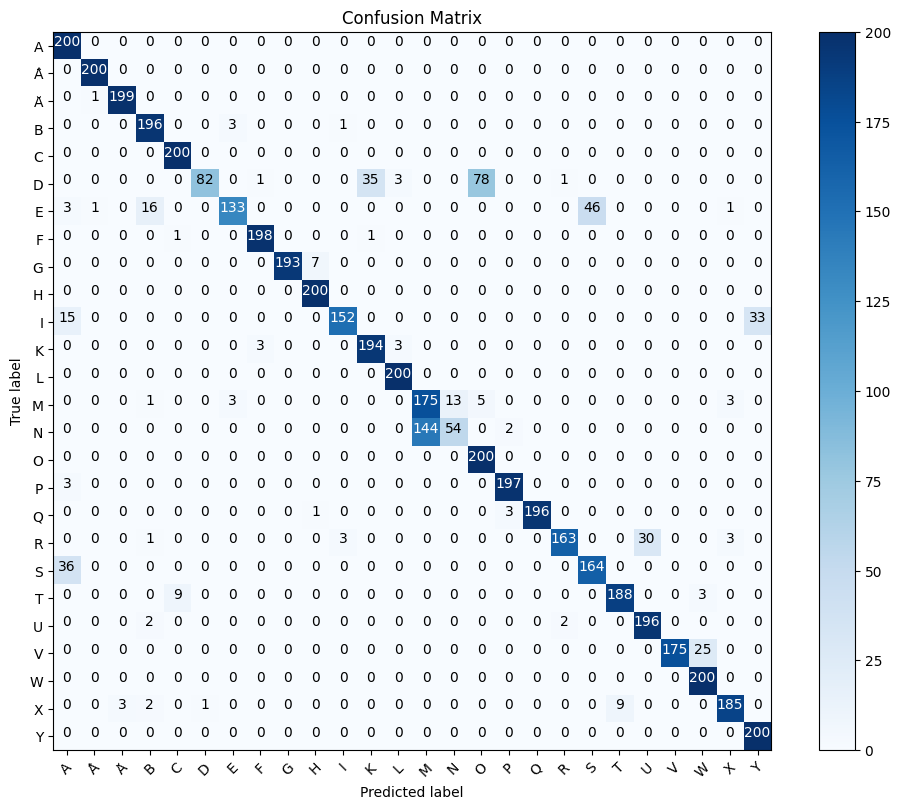

In [ ]:
plot_confusion_matrix(vgg16_model, test_dataset, features=test_features, labels=test_labels)